# Building Pulse Schedules

Building `Schedule`s is very straightforward, yet there are a few ways to compose them. We're going to explore these different methods here.

In this tutorial we use the `Play` instruction, with a `ConstantPulse` pulse argument. To learn about these and other `Instruction`s, first check out [this page](building_pulse_instructions.ipynb).

Tip: `Instruction`s can be treated just like `Schedule`s -- that means all the methods we use here work equally well for composing `Schedule`s with `Schedule`s, `Instruction`s with `Instruction`s, or between the two.

As the basis for trying out the composition methods, let's initialize a couple dummy `Schedule`s.

In [1]:
from qiskit.pulse import Schedule, Play, ConstantPulse, Delay, DriveChannel

sched_a = Schedule(name="A")
sched_b = Schedule(name="B")

### `insert` or `|`

The `insert` method schedules an `Instruction` or `Schedule` at a particular time. Let's use it to give each of our schedules a different instruction.

The insert schedule method overloads the `|` (or) operator for `Schedule`s, so we will use this special syntax on schedule `B`. When using this syntactic sugar, the `time` argument is implicitly zero.

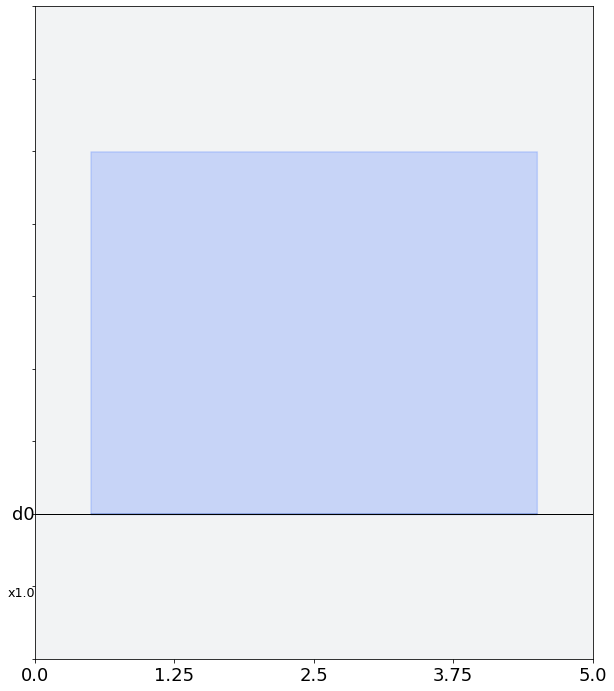

In [2]:
sched_a = sched_a.insert(0, Play(ConstantPulse(duration=5, amp=1), DriveChannel(0)))
sched_b |= Play(ConstantPulse(duration=5, amp=-1), DriveChannel(0))

sched_a.draw()

### `shift` or `<<`

Sometimes we need to offset one schedule from `time=0`. For instance, when using `|`, we use `shift` to add an instruction at a time besides zero.

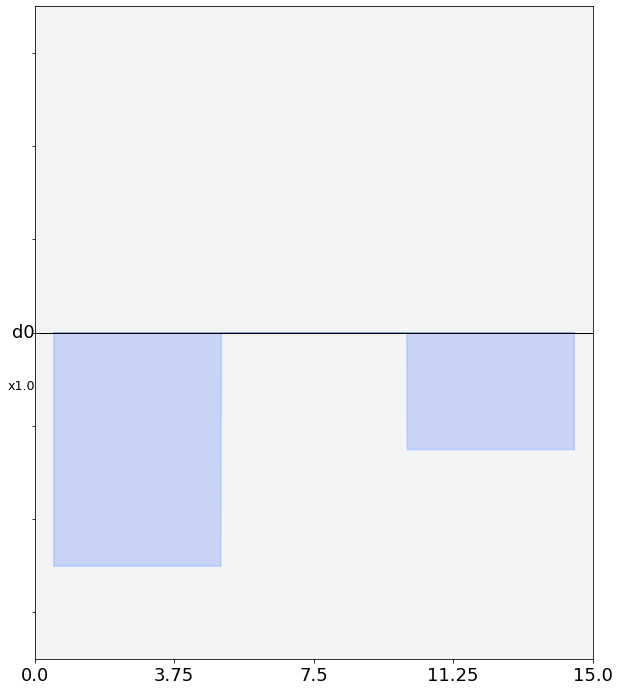

In [3]:
sched_a |= Play(ConstantPulse(duration=5, amp=0.5), DriveChannel(0)).shift(10)
sched_b |= Play(ConstantPulse(duration=5, amp=-0.5), DriveChannel(0)) << 10

sched_b.draw()

Let's see how we can use `insert` to compose schedules `A` and `B` together.

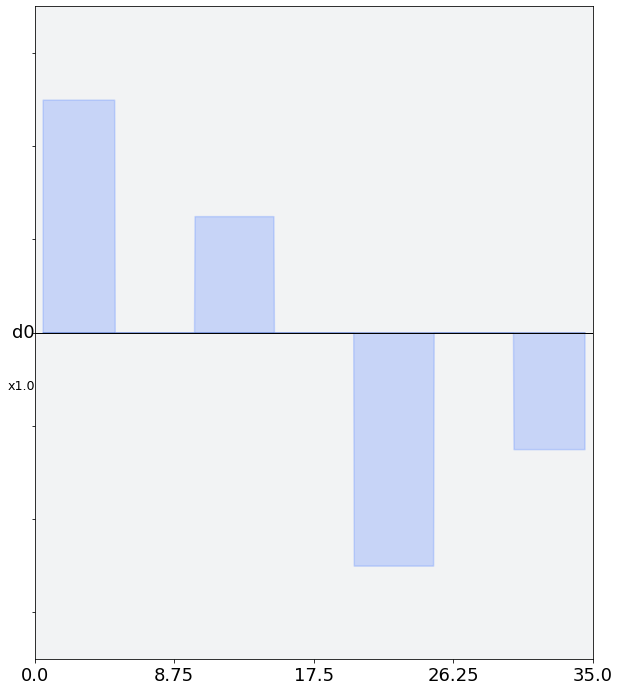

In [4]:
sched_a_and_b = sched_a.insert(20, sched_b)  # A followed by B at time 20
sched_b_and_a = sched_a | sched_b << 20      # B followed by A at time 20

sched_a_and_b.draw()

### `append` or `+`

The `append` method is like `insert`, but the insertion time is determined for us. The `Instruction` or `Schedule` being added will begin when all the channels common to the two become free. If they contain no common channels, then the `Schedule` will be appended at `time=0`. In psuedocode:

```
time = 0
for channel in intersection(original_sched_channels, appended_sched_channels):
    time = max(time, original_sched.duration(channel))
```

The append schedule method overloads the `+` (add) operator for Schedules.

Let's continue with schedule `A` and schedule `B`. Remember that they both have instructions scheduled on the same channel, `DriveChannel(0)`. Schedule `A` contains positive amplitude pulses, and schedule `B` contains negative amplitude pulses.

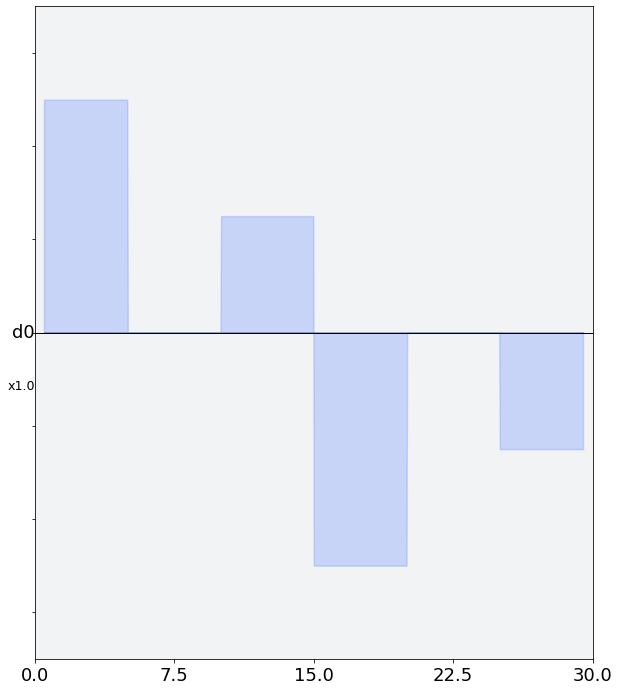

In [5]:
sched_a_plus_b = sched_a.append(sched_b)

sched_a_plus_b.draw()

Let's see what happens when there are no common channels.

Warning: Common channels is not the same as common qubits. Measurements require different channels than gate operations, even on one qubit. If you simply append a measurement to a schedule, you'll likely schedule your measurement at `time=0`, not what you were expecting! Instead, use the shift operation, with `schedule.duration` as the time argument.

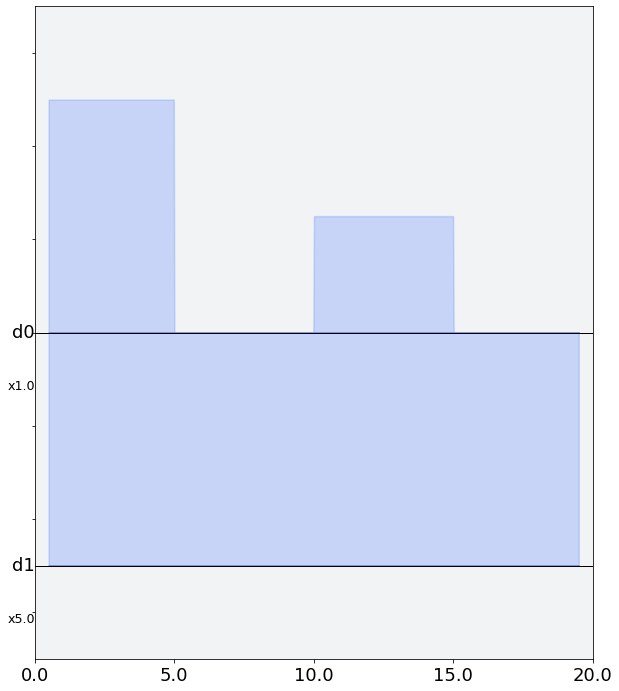

In [6]:
sched_a_plus_c = sched_a + Play(ConstantPulse(duration=20, amp=0.2), DriveChannel(1))

sched_a_plus_c.draw()

This time, the new instruction being appended was added at `time=0`, because it did not have any instructions on `DriveChannel(0)`.

Be wary: `append` only "slides" the appended schedule into the original around channels that are not common between them. The following example demonstrates this point.

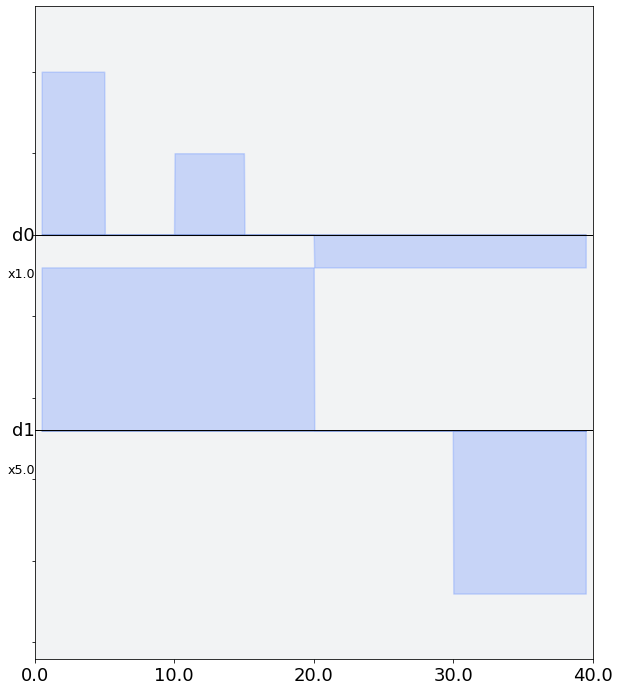

In [7]:
sched_d = Play(ConstantPulse(duration=20, amp=-0.2), DriveChannel(0)) \
          + (Play(ConstantPulse(duration=10, amp=-0.2), DriveChannel(1)) << 10)

(sched_a_plus_c + sched_d).draw()

Congrats, you've mastered schedule composition!

On the next page, we will see how to [add measurements to your schedule](adding_measurements.ipynb).

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright